In [23]:
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
# import os
# os.environ['LD_LIBRARY_PATH'] = '/home/baris/miniconda3/envs/verifiers/lib/python3.11/site-packages/nvidia/nvjitlink/lib'

In [25]:
import json
import textwrap
import pandas as pd
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import HBox
import matplotlib.pyplot as plt
from tabulate import tabulate


In [26]:
exp_name = "tarry-tosh"
preds_fp = f"../../tmp/dvc/{exp_name}/data/generated/predictions.jsonl"
results_fp = f"../../tmp/dvc/{exp_name}/data/generated/results.jsonl"
preds_df = pd.read_json(preds_fp, lines=True)
results_df = pd.read_json(results_fp, lines=True)
df = pd.merge(preds_df, results_df, on="id", suffixes=('', '_right'))
# Drop duplicate columns from the right dataframe (keep left)
dupe_cols = [col for col in df.columns if col.endswith('_right')]
df = df.drop(columns=dupe_cols)
df.head()

,id,answer,prompt,docs,answers,supporting_doc_slugs,n_hops,trajectory,predicted_answer,exact_match,f1,supporting_doc_ids,retrieved_doc_ids,supporting.precision,supporting.recall,supporting.f1,citation.precision,citation.recall,citation.f1
0,2hop__460946_294723,Miquette Giraudy,[{'content': 'Answer the question based on the...,[{'body': 'Grant's First Stand is the debut al...,"[miquette giraudy, Miquette Giraudy]","[5. Miquette Giraudy, 10. Green (Steve Hillage...",2,[{'content': 'Answer the question based on the...,Steve Hillage.,0,0.0,"[10, 5]","[1, 0, 5]",0.333333,0.5,0.400000,1.0,1.0,1.000000
1,2hop__252311_366220,Mike Medavoy,[{'content': 'Answer the question based on the...,[{'body': 'SICRAL 1B is a military communicati...,"[mike medavoy, Mike Medavoy]","[6. Mike Medavoy, 10. UHF (film)]",2,[{'content': 'Answer the question based on the...,Mike Medavoy,1,1.0,"[10, 6]","[10, 6]",1.000000,1.0,1.000000,1.0,0.5,0.666667
2,2hop__701895_752697,Tamaulipas,[{'content': 'Answer the question based on the...,[{'body': 'Pangi Territory is an administrativ...,"[Tamaulipas, tamaulipas]","[3. Nuevo Laredo Municipality, 11. Ciudad Depo...",2,[{'content': 'Answer the question based on the...,The state of Tamaulipas.,0,0.5,"[3, 11]","[3, 11]",1.000000,1.0,1.000000,1.0,1.0,1.000000
3,2hop__259228_793698,Cologne,[{'content': 'Answer the question based on the...,"[{'body': 'Other Fortune 500 companies, while ...","[cologne, Cologne]","[11. Philae (spacecraft), 14. Ulrich Walter]",2,[{'content': 'Answer the question based on the...,"Chicago, Illinois",0,0.0,"[14, 11]",[14],1.000000,0.5,0.666667,0.5,0.5,0.500000
4,2hop__481349_302087,Bombardier Inc.,[{'content': 'Answer the question based on the...,[{'body': 'Market Square is a furniture showro...,"[Bombardier Inc., bombardier inc., bombardier,...","[5. List of Bombardier CRJ operators, 10. Lear...",2,[{'content': 'Answer the question based on the...,Bombardier Inc.,1,1.0,"[10, 5]","[10, 5]",1.000000,1.0,1.000000,1.0,1.0,1.000000


In [27]:
df["missing_doc_ids"] = df.apply(
    lambda row: list(set(doc["id"] for doc in row["docs"] if doc["is_supporting"]) - set(row["retrieved_doc_ids"])),
    axis=1,
)

In [28]:
# from verifiers.rubrics.musique import musique_f1_reward_func, musique_em_reward_func, musique_supporting_f1_reward_func, musique_supporting_recall_reward_func

# em_rewards = musique_em_reward_func(df['trajectory'].values, df['answers'].values, [2] * len(df))
# df['reward.em'] = em_rewards

# f1_rewards = musique_f1_reward_func(df['trajectory'].values, df['answers'].values, [2] * len(df))
# df['reward.f1'] = f1_rewards

# supporting_f1_rewards = musique_supporting_f1_reward_func(df['trajectory'].values, df['docs'].values)
# df['reward.supporting_f1'] = supporting_f1_rewards

# supporting_recall_rewards = musique_supporting_recall_reward_func(df['trajectory'].values, df['docs'].values)
# df['reward.supporting_recall'] = supporting_recall_rewards

In [29]:
df[['exact_match', 'f1', 'supporting.f1', 'supporting.recall', 'citation.f1', 'citation.recall']].describe()

,exact_match,f1,supporting.f1,supporting.recall,citation.f1,citation.recall
count,12085.000000,12085.000000,12085.000000,12085.000000,12085.000000,12085.000000
mean,0.480761,0.597602,0.810444,0.792546,0.722801,0.689698
std,0.499650,0.442760,0.252948,0.269389,0.334821,0.344393
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.666667,0.666667,0.500000,0.500000
50%,0.000000,0.800000,1.000000,1.000000,0.800000,0.750000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
df.groupby("n_hops").agg(
    {
        "exact_match": ["mean", "std"],
        "f1": ["mean", "std"],
        "supporting.f1": ["mean", "std"],
        "supporting.recall": ["mean", "std"],
        "citation.f1": ["mean", "std"],
        "citation.recall": ["mean", "std"],
    }
).round(3)

exact_match            f1        supporting.f1         \
              mean    std   mean    std          mean    std   
n_hops                                                         
2            0.514  0.500  0.635  0.431         0.842  0.270   
3            0.464  0.499  0.599  0.439         0.807  0.227   
4            0.410  0.492  0.481  0.466         0.720  0.222   

       supporting.recall        citation.f1        citation.recall         
                    mean    std        mean    std            mean    std  
n_hops                                                                     
2                  0.849  0.275       0.775  0.346           0.770  0.353  
3                  0.775  0.246       0.721  0.296           0.667  0.301  
4                  0.650  0.234       0.564  0.319           0.483  0.299

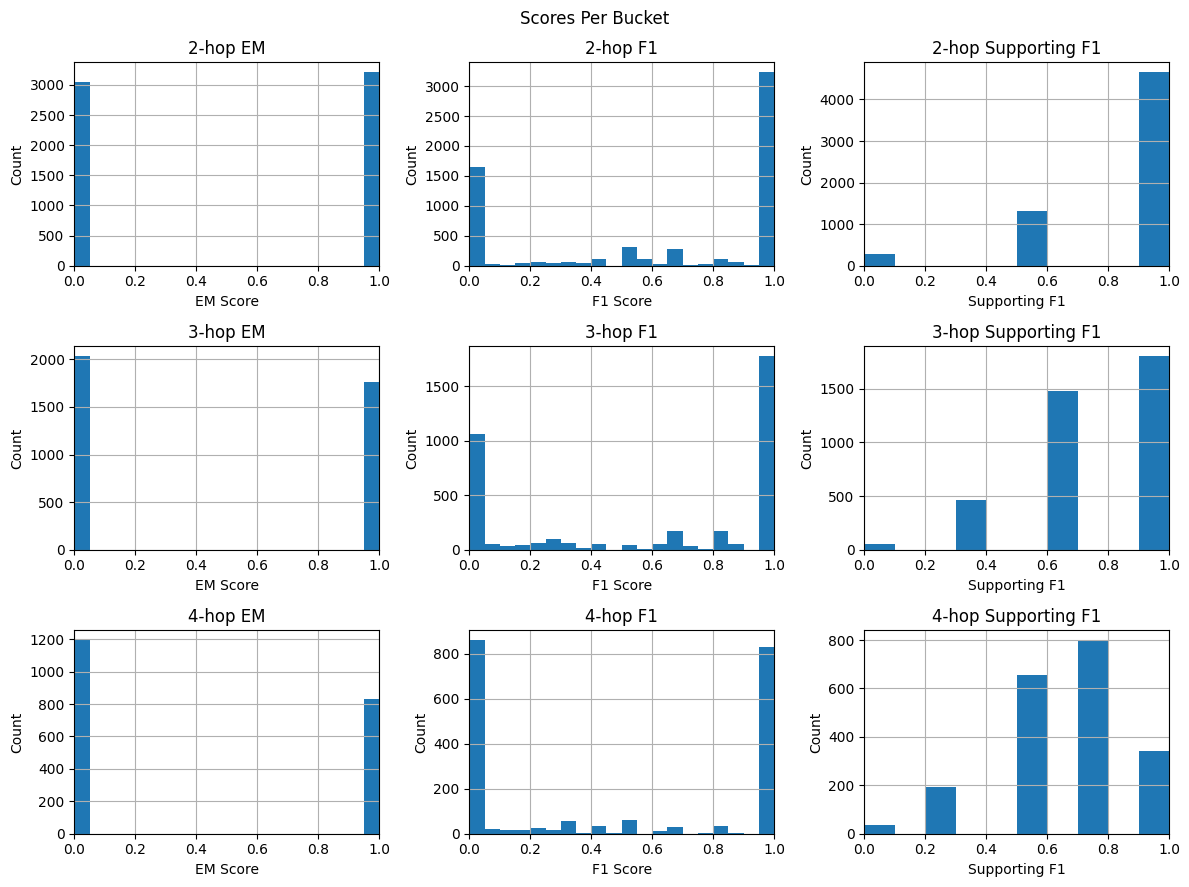

In [31]:
# Visualize rewards per n_hops
n_hops = sorted(df['n_hops'].unique())
fig, axes = plt.subplots(len(n_hops), 3, figsize=(12, 9))
fig.suptitle('Scores Per Bucket')

for i, n_hop in enumerate(n_hops):
    subset = df[df['n_hops'] == n_hop]
    
    subset['exact_match'].hist(ax=axes[i,0], bins=20)
    axes[i,0].set_title(f'{n_hop}-hop EM')
    axes[i,0].set_xlabel('EM Score')
    axes[i,0].set_ylabel('Count')
    axes[i,0].set_xlim(0, 1)
    
    subset['f1'].hist(ax=axes[i,1], bins=20)
    axes[i,1].set_title(f'{n_hop}-hop F1')
    axes[i,1].set_xlabel('F1 Score')
    axes[i,1].set_ylabel('Count')
    axes[i,1].set_xlim(0, 1)
    
    subset['supporting.recall'].hist(ax=axes[i,2])
    axes[i,2].set_title(f'{n_hop}-hop Supporting F1')
    axes[i,2].set_xlabel('Supporting F1')
    axes[i,2].set_ylabel('Count')
    axes[i,2].set_xlim(0, 1)


plt.tight_layout()


In [32]:
row = df.iloc[0]
row['prompt']

[{'content': 'Answer the question based on the information provided by tools. You have access to the following tools:\n====\nsearch: Retrieve for relevant documents by the query. The results become better if the query is more specific. It excludes documents that have already been retrieved.\n\nArguments:\n  - query: \n----\nget_doc: Get the document by the id.\n\nArguments:\n  - id: \n====\n\nFor each step:\n1. Think through your reasoning inside <think> tags\n2. If needed, use a tool by writing a JSON command inside <tool> tags with:\n   - "name": the tool to use\n   - "args": the arguments for the tool\nFor instance,\n<tool>\n{\n  "name": "search",\n  "args": {\n    "query": "..."\n  }\n}\n</tool>\n3. You will see the tool\'s output inside <result> tags\n4. Continue until you have found the answer\n5. In the **last** step, \n  - Reflect on your previous steps inside <think> tags\n  - Cite the documents you used to answer the question inside <cite> tags by their IDs, e.g. `<cite>1, 2,

In [35]:
import textwrap
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import HBox

def fixedwidth(text):
    if not isinstance(text, str):
        text = str(text)
    return "\n".join(textwrap.wrap(text, width=80, replace_whitespace=False))

def format_conversation(messages: list[dict]) -> str:
    return "\n".join([f"{msg['role']}: {msg['content']}" for msg in messages])

def format_row(row):
    question = row['prompt'][-1]['content']
    idx_of_question = next((i for i, msg in enumerate(row['trajectory']) if msg['role'] == 'user' and msg['content'] == question), None)
    output = []
    output.append(f"{row['id']} - {row['n_hops']} hops")
    output.append("="*80)
    output.append("Q: " + row['prompt'][-1]['content'])
    output.append("Reference Answers: " + str(row['answers']))
    output.append("Predicted Answer: " + str(row['predicted_answer']))
    output.append("")
    output.append("# Scores")
    output.append("EM: {:.3f}".format(row['exact_match']))
    output.append("F1: {:.3f}".format(row['f1']))
    output.append("Supporting F1: {:.3f}".format(row['supporting.f1']))
    output.append("Supporting Recall: {:.3f}".format(row['supporting.recall']))
    output.append("Citation F1: {:.3f}".format(row['citation.f1']))
    output.append("Citation Recall: {:.3f}".format(row['citation.recall']))
    output.append("")
    # output.append("Supporting Titles: " + str(row['supporting_titles']))
    # output.append("Retrieved Titles: " + str(row['retrieved_titles']))
    # output.append("Missing Titles: " + str(row['missing_titles']))
    output.append("\n")
    output.append("="*80)
    output.append(format_conversation(row['trajectory'][idx_of_question:]))
    output.append("="*80)
    return "\n".join(output)

def present_row(row):
    print(format_row(row))

def create_browse_app(dataf):
    def browse_failed(i=0):
        row = dataf.iloc[i]
        present_row(row)

    index = widgets.IntText(value=0, description='Index:')
    left_button = widgets.Button(description='Previous')
    right_button = widgets.Button(description='Next')

    def on_left_button_clicked(b):
        if index.value > 0:
            index.value -= 1

    def on_right_button_clicked(b):
        if index.value < len(dataf) - 1:
            index.value += 1

    left_button.on_click(on_left_button_clicked)
    right_button.on_click(on_right_button_clicked)

    ui = HBox([left_button, index, right_button])
    out = widgets.interactive_output(browse_failed, {'i': index})

    display(ui, out)

# Create app focused on failed examples
inspect_df = df[df['f1'] < 1.0].sort_values('f1')
create_browse_app(inspect_df)


Output()

In [38]:
retrieval_failure_mask = df['supporting.recall'] < 0.95
retrieval_failure_mask.sum() / len(df)

0.4369052544476624

In [39]:
reasoning_failure_mask = (df['f1'] < 0.5) & ~retrieval_failure_mask
reasoning_failure_mask.sum() / len(df)

0.12743069921390154

In [40]:
unfaithful_success_mask = (df['f1'] > 0.5) & retrieval_failure_mask
unfaithful_success_mask.sum() / len(df)

0.17004551096400497

In [41]:
create_browse_app(df.loc[retrieval_failure_mask])

Output()